In [335]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Helper Functions

In [336]:
def add_noise(df, scale):
    noise = pd.DataFrame(np.random.normal(loc=0, scale=scale, size=df.shape), columns=df.columns)

    df_noisy = noise.add(df)

    return df_noisy

In [337]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values.astype(np.float32)).to(device)

# Prepare Data

In [338]:
# read data
spectrum_train = pd.read_excel('spectrum_train.xlsx')
spectrum_test = pd.read_excel('spectrum_valid.xlsx')
temp_train = pd.read_excel('temp_train.xlsx')
temp_test = pd.read_excel('temp_valid.xlsx')

In [339]:
# scale spectrum data
data_scale = 10**12
spectrum_train = spectrum_train.multiply(data_scale)
spectrum_test = spectrum_test.multiply(data_scale)

In [340]:
# set train and test data

# 1 - noise added to training data
# 0 - no noise added
noise_scale = 10
noise = 0

if noise:
    temp_train = add_noise(temp_train, noise_scale)

x_train = temp_train
x_test = temp_test
y_train = spectrum_train
y_test = spectrum_test

In [341]:
# create input and output tensors for the forward model
x = df_to_tensor(x_train)
y = df_to_tensor(y_train)

In [342]:
n_samples, middle_size = x.shape
_, output_size = y.shape
print(f'y shape: {y.shape}')
print(f'x shape: {x.shape}')

y shape: torch.Size([2000, 66])
x shape: torch.Size([2000, 11])


# Design Model 

### Forward Model — middle_size to output_size

In [343]:
class ForwardNet(nn.Module):
    def __init__(self, middle_size, output_size):
        super(ForwardNet, self).__init__()
        self.lin1 = nn.Linear(middle_size, 30)
        self.lin2 = nn.Linear(30, 30)
        self.lin_fin = nn.Linear(30, output_size)

    def forward(self, x):
        output = F.leaky_relu(self.lin1(x))
        output = F.leaky_relu(self.lin2(output))
        output = self.lin_fin(output)
        return output

In [344]:
class InverseNet(nn.Module):
    def __init__(self, output_size, middle_size, out_transform=nn.Sigmoid()):
        super(InverseNet, self).__init__()
        self.lin1 = nn.Linear(output_size, 30)
        self.lin2 = nn.Linear(30, 30)
        self.lin_fin = nn.Linear(30, middle_size)
        self.out_transform = out_transform

    def forward(self, y):
        print(y.shape)
        h = F.leaky_relu(self.lin1(y))
        h = F.leaky_relu(self.lin2(h))
        h = F.leaky_relu(self.lin2(h))
        h = F.leaky_relu(self.lin2(h))
        h = F.leaky_relu(self.lin2(h))
        o = self.lin_fin(h)
        if self.out_transform:
            o = self.out_transform(o)
        return o

In [345]:
class TandemNet(nn.Module):

    def __init__(self, forward_model, inverse_model):
        super(TandemNet, self).__init__()
        self.forward_model = forward_model
        self.inverse_model = inverse_model

    def forward(self, y):
        '''
        Args:
            y: true CIE coordinates
        
        Returns:
            x_: predicted structural parameters
            y_: predicted CIE coordinates for the inversely-designed structure

        '''
        pred_temp = self.inverse_model(y)
        pred_spec = self.forward_model(pred_temp)
        return pred_temp, pred_spec

In [346]:
forward_model = ForwardNet(middle_size, output_size)
inverse_model = InverseNet(output_size, middle_size)
tandem_net = TandemNet(forward_model, inverse_model)
# print(type(inverse_model(x)))
print(forward_model(inverse_model(y)))
print(tandem_net(y))

torch.Size([2000, 66])
tensor([[-0.0583,  0.0038, -0.3160,  ..., -0.1063, -0.0602, -0.1950],
        [-0.0583,  0.0038, -0.3160,  ..., -0.1063, -0.0602, -0.1950],
        [-0.0582,  0.0037, -0.3160,  ..., -0.1063, -0.0603, -0.1950],
        ...,
        [-0.0583,  0.0038, -0.3160,  ..., -0.1063, -0.0602, -0.1950],
        [-0.0583,  0.0038, -0.3160,  ..., -0.1063, -0.0602, -0.1950],
        [-0.0584,  0.0038, -0.3160,  ..., -0.1063, -0.0602, -0.1950]],
       grad_fn=<AddmmBackward0>)
torch.Size([2000, 66])
(tensor([[0.4470, 0.4807, 0.5594,  ..., 0.4940, 0.4874, 0.4850],
        [0.4469, 0.4807, 0.5594,  ..., 0.4940, 0.4874, 0.4850],
        [0.4474, 0.4817, 0.5585,  ..., 0.4936, 0.4864, 0.4850],
        ...,
        [0.4471, 0.4810, 0.5591,  ..., 0.4939, 0.4871, 0.4850],
        [0.4470, 0.4808, 0.5593,  ..., 0.4940, 0.4873, 0.4850],
        [0.4470, 0.4806, 0.5595,  ..., 0.4941, 0.4876, 0.4850]],
       grad_fn=<SigmoidBackward0>), tensor([[-0.0583,  0.0038, -0.3160,  ..., -0.1063, -

# Construct Loss and Optimizer

In [347]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Rprop(forward_model.parameters(), lr=learning_rate)
optimizer = torch.optim.Rprop(forward_model.parameters(), lr=learning_rate)

# Training Loop

In [ ]:
def train_forward_model(forward_model, x, y):

    forward_loss_list = []
    num_forward_epochs = 1000

    for epoch in range(num_forward_epochs):
        # forward pass and loss
        y_predicted = forward_model(x)
        loss = criterion(y_predicted, y)
        forward_loss_list.append(loss.item())

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # empty gradients
        optimizer.zero_grad()

        if (epoch+1) % int(num_forward_epochs/10) == 0:
            print(f'forward epoch: {epoch+1}, forward loss = {loss:.4f}')

    return num_forward_epochs, forward_loss_list

In [ ]:
def train_inverse_model(inverse_model, x, y):

    inverse_loss_list = []
    num_inverse_epochs = 1000

    for epoch in range(num_inverse_epochs):
        # forward pass and loss
        x_predicted = inverse_model(y)
        loss = criterion(x_predicted, x)
        inverse_loss_list.append(loss.item())

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # empty gradients
        optimizer.zero_grad()

        if (epoch+1) % int(num_inverse_epochs/10) == 0:
            print(f'inverse epoch: {epoch+1}, inverse loss = {loss:.4f}')

    return num_inverse_epochs, inverse_loss_list

In [ ]:
train_forward_model(forward_model, x, y)
train_inverse_model(forward_model, x, y)

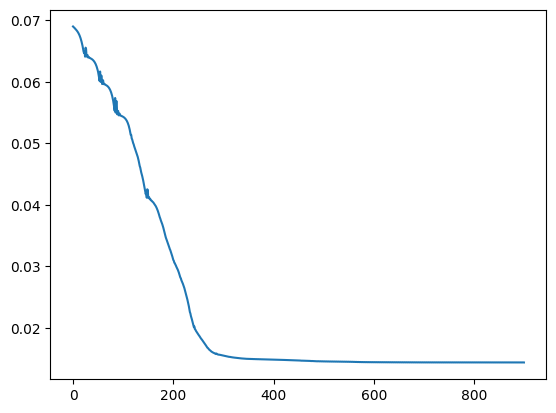

In [ ]:
# # forward loss
# plt.plot(forward_loss_list[100:num_forward_epochs])
# plt.plot(inverse_loss_list[100:num_inverse_epochs])

# Plots

### Clean

In [ ]:
# pred = model(df_to_tensor(X_test))
# pred = pd.DataFrame(pred.detach().numpy())

# actual = y_test

In [ ]:
# import matplotlib.pyplot as plt
# import random

# def plot_actual_vs_pred(index):
#     actual_np = actual.values[index]
#     pred_np = pred.values[index]


#     plt.plot(y_train.columns, actual_np, label='actual')
#     plt.plot(y_train.columns, pred_np, 'r+', label='predicted')

#     if direction:
#         plt.title("Temperature to Spectrum")
#         plt.xlabel("Wavlength")
#         plt.ylabel("Intensity")
#     else:
#         plt.title("Spectrum to Temperature")
#         plt.xlabel("Layer")
#         plt.ylabel("Temperature (K)")

#     plt.legend()
#     plt.show()

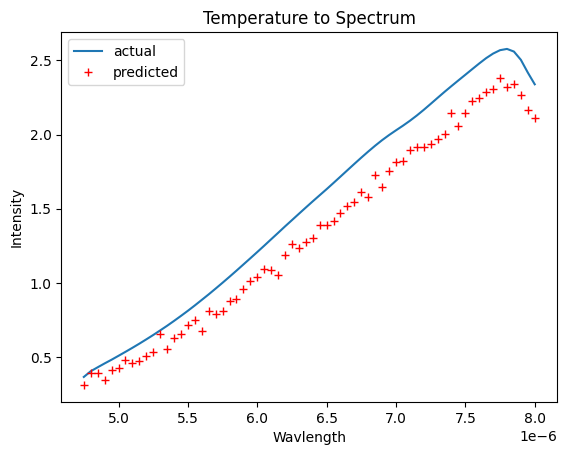

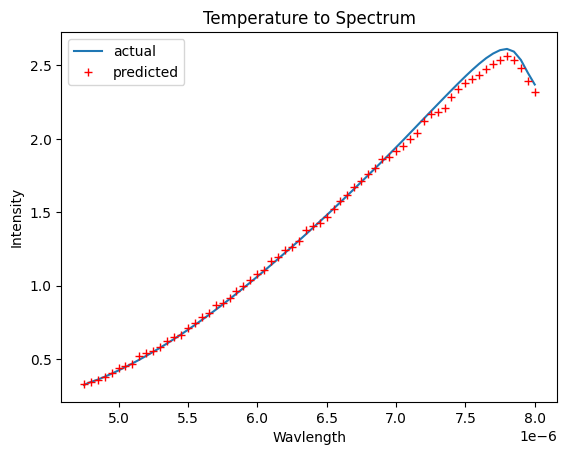

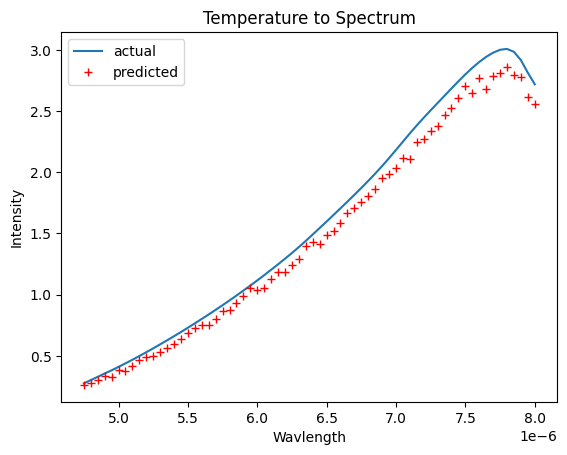

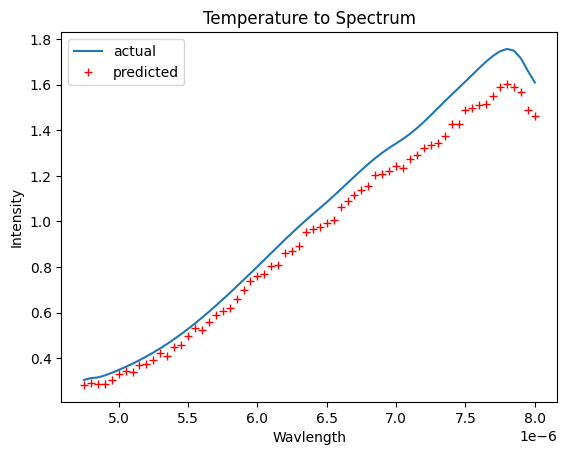

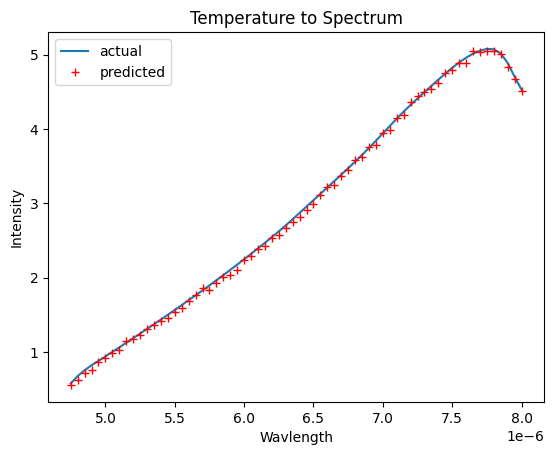

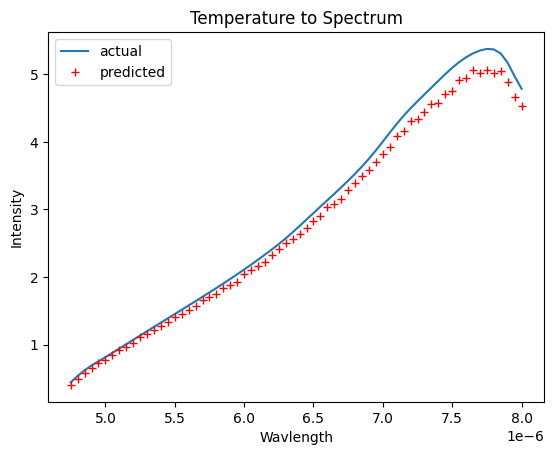

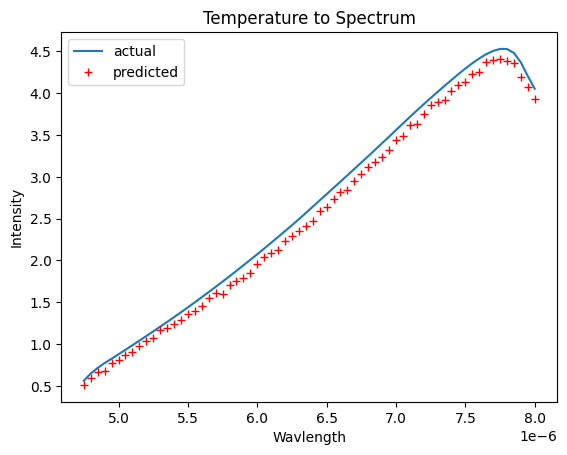

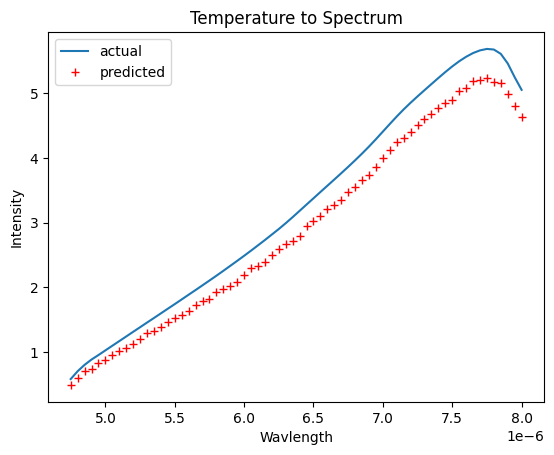

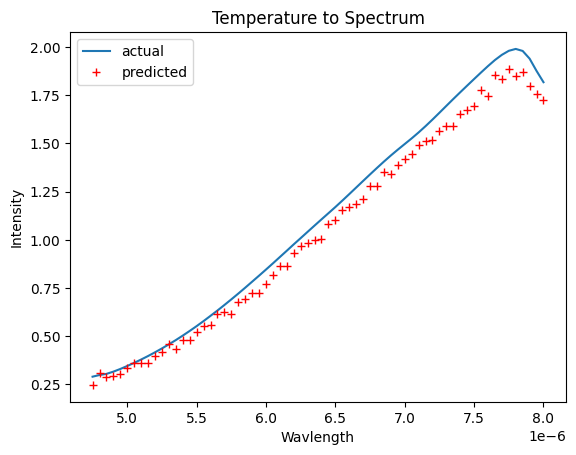

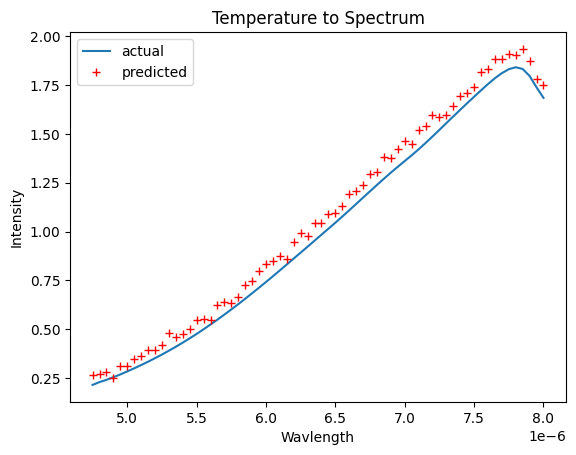

In [ ]:
# for index in range(10):
#     plot_actual_vs_pred(index*10)